In [329]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from statannotations.Annotator import Annotator
from matplotlib.colors import to_rgba
import matplotlib.ticker as mticker
import nengo
import time
from NEF_syn import *
from environments import *
from fit import *
from plot_spikes import *
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.patches import Patch

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="DejaVu Sans")
plt.rcParams["font.family"] = "CMU Serif"  # close to LaTeX default
plt.rcParams["mathtext.fontset"] = "cm"   # LaTeX-style math
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = True
# Global font sizes for different elements
plt.rcParams.update({
    "font.size": 12,            # general font size
    "axes.titlesize": 12,       # axes title
    "axes.labelsize": 12,       # x and y labels
    "xtick.labelsize": 12,      # x tick labels
    "ytick.labelsize": 12,      # y tick labels
    "legend.fontsize": 10,      # legend
})


# Figure 1 - Dynamic learning Rate

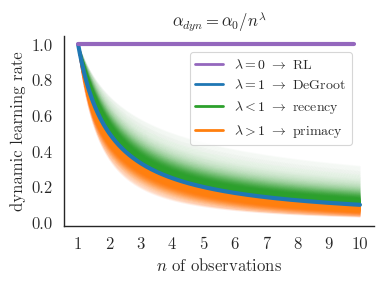

In [128]:
# x values
n = np.linspace(1, 10, 500)

# Parameters
lambda_center = 1
lambda_lower = 0.5
lambda_upper = 1.5
num_lines = 200
k = 5  # controls steepness of exponential fade

# Assign colors from palette
color_center = palette[0]  # center line
color_upper = palette[1]   # upper λ
color_lower = palette[2]   # lower λ
color_rl = palette[4]
plt.figure(figsize=(4,3))

# Lower λ gradient (lambda < 1)
for i in range(num_lines + 1):
    frac = i / num_lines
    lam = lambda_center - frac * (lambda_center - lambda_lower)
    alpha = np.exp(-k * frac)  # exponential decay
    plt.plot(n, 1/n**lam, color=color_lower, alpha=alpha)

# Upper λ gradient (lambda > 1)
for i in range(num_lines + 1):
    frac = i / num_lines
    lam = lambda_center + frac * (lambda_upper - lambda_center)
    alpha = np.exp(-k * frac)  # exponential decay
    plt.plot(n, 1/n**lam, color=color_upper, alpha=alpha)

# Center line
plt.plot(n, 1/n**lambda_center, color=color_center, linewidth=3, label=r"$\alpha_{DG} = 1/n$")
plt.plot(n[:-10], np.ones_like(n[:-10]), color=palette[4], linewidth=3, label=r"$\alpha_{RL} = \alpha_0$")
plt.xlabel(r"$n$ of observations")
plt.ylabel("dynamic learning rate")
plt.xticks(np.arange(1,11))
plt.yticks(np.arange(0,1.1,0.2))
plt.title(r"$\alpha_{dyn} = \alpha_0/n^\lambda$")
# plt.title(r"$\alpha_{dyn} = \frac{\alpha_0}{n^\lambda}$")
legend_elements = [
    Line2D([0], [0], color=color_rl, lw=2, label=r"$\lambda = 0 ~\rightarrow $ RL"),
    Line2D([0], [0], color=color_center, lw=2, label=r"$\lambda = 1 ~\rightarrow $ DeGroot"),
    Line2D([0], [0], color=color_lower, lw=2, label=r"$\lambda < 1 ~\rightarrow $ recency"),
    Line2D([0], [0], color=color_upper, lw=2, label=r"$\lambda > 1 ~\rightarrow $ primacy"),
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("figures/figure1.pdf")
plt.show()

# Figure 2 - NEF model architecture

# Figure 3 - NEF spiking activities and decoded states

In [119]:
trial = 2
sid = 1
alpha = 1e-3
lambd = 1.0
z = 0
n_neurons = 300
dataset = 'carrabin'

empirical = pd.read_pickle(f"data/{dataset}.pkl").query("sid==@sid")
trials = empirical['trial'].unique() 
W = np.zeros((1, n_neurons))
for t in trials[:20]:
    print(f"training sid {sid}, trial {t}")
    env = EnvironmentCount(dataset, sid=sid, trial=t, lambd=lambd, iti_noise=0)
    net, sim, W = simulate_NEF_syn(W, env, alpha=alpha, n_neurons=n_neurons, z=z, seed_net=sid, train=True)
print(f"running sid {sid}, trial {trial}")
env = EnvironmentCount(dataset, sid=sid, trial=trial, lambd=lambd, iti_noise=0)
net, sim = simulate_NEF_syn(W, env, alpha=alpha, n_neurons=n_neurons, z=z, seed_net=sid, train=False)
obs_times = env.obs_times

training sid 1, trial 1
training sid 1, trial 2
training sid 1, trial 3
training sid 1, trial 4
training sid 1, trial 5
training sid 1, trial 6
training sid 1, trial 7
training sid 1, trial 8
training sid 1, trial 9
training sid 1, trial 10
training sid 1, trial 11
training sid 1, trial 12
training sid 1, trial 13
training sid 1, trial 14
training sid 1, trial 15
training sid 1, trial 16
training sid 1, trial 17
training sid 1, trial 18
training sid 1, trial 19
training sid 1, trial 20
running sid 1, trial 2


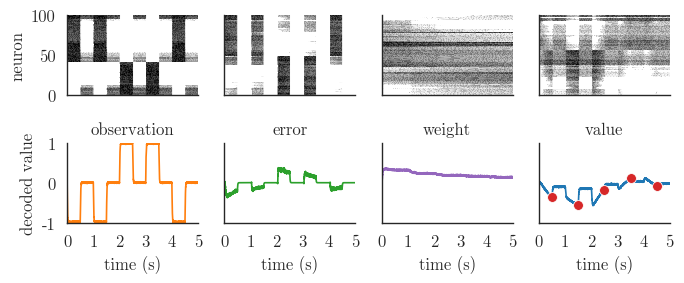

In [159]:
RL_0 = [get_expectations_carrabin("RL_n", [0.2, 0], sid, trial, stage) for stage in range(1,6)]
RL_0.insert(0, 0)

times = sim.trange().flatten()
# input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_stim].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error_value].flatten()
value = sim.data[net.probe_value].flatten()
context = sim.data[net.probe_context]
obs_times = np.array(env.obs_times)*env.dt

obs_spikes = sim.data[net.probe_stim_spikes]
weight_spikes = sim.data[net.probe_weight_spikes]
error_spikes = np.hstack([sim.data[net.probe_error1_spikes], sim.data[net.probe_error2_spikes]])
value_spikes = sim.data[net.probe_value_spikes]
context_spikes = sim.data[net.probe_context_spikes]
times2, obs_spikes2 = preprocess_spikes(times, obs_spikes, num=100, sample_size=100)
times2, weight_spikes2 = preprocess_spikes(times, weight_spikes, num=100, sample_size=100)
times2, error_spikes2 = preprocess_spikes(times, error_spikes, num=100, sample_size=100)
times2, value_spikes2 = preprocess_spikes(times, value_spikes, num=100, sample_size=100)
times2, context_spikes2 = preprocess_spikes(times, context_spikes, num=100, sample_size=100)


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7,3), sharex=True, sharey='row')

# --- Top row: spikes ---
plot_spikes(times2, obs_spikes2, ax=axes[0][0])
plot_spikes(times2, error_spikes2, ax=axes[0][1])
plot_spikes(times2, weight_spikes2, ax=axes[0][2])
plot_spikes(times2, value_spikes2, ax=axes[0][3])

axes[0][0].set(ylabel='neuron')
for ax in axes[0,1:]:
    ax.set(ylabel='')

# --- Bottom row: line plots ---
sns.lineplot(x=times, y=obs, ax=axes[1][0], color=palette[1])
sns.lineplot(x=times, y=error, ax=axes[1][1], color=palette[2])
sns.lineplot(x=times, y=weight, ax=axes[1][2], color=palette[4])
sns.lineplot(x=times, y=value, ax=axes[1][3], color=palette[0])
sns.scatterplot(x=obs_times, y=value[env.obs_times], ax=axes[1][3], color=palette[3], s=50, zorder=10)

axes[1][0].set(title='observation', xlim=[0,5], ylim=[-1,1], yticks=[-1,0,1], xticks=[0,1,2,3,4,5], ylabel='decoded value')
axes[1][0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
axes[1][1].set(title='error')
axes[1][2].set(title='weight')
axes[1][3].set(title='value')

for ax in axes[1,:]:
    ax.set(xlabel='time (s)')

# Remove top/right spines
axes_flat = axes.flatten()
for ax in axes_flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig("figures/figure3a.svg")

# Figure 4 - Evidence of Individual Variability across Three Cognitive Tasks

In [160]:
carrabin = pd.read_pickle("data/carrabin_excursions.pkl")
sigma_excursions = pd.read_pickle("data/sigma_excursions.pkl")
jiang = pd.read_pickle("data/switch_vs_conflict.pkl").query("type=='Human'")
jiang_logistic = pd.read_pickle("data/switch_vs_conflict_logistic.pkl").query("type=='Human'")
yoo = pd.read_pickle("data/temporal_weighting.pkl").query("type=='Human'")
yoo_powerlaw = pd.read_pickle("data/temporal_weighting_powerlaw.pkl")

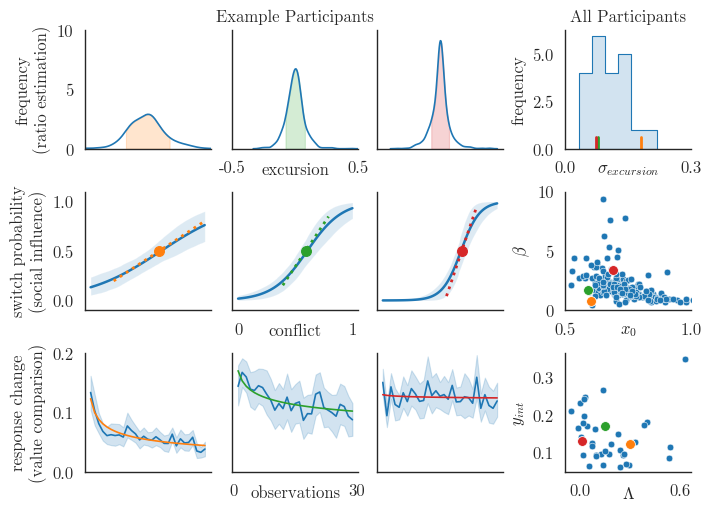

In [197]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(7,5), sharey=False, constrained_layout=True)

# Carrabin
sids_carrabin = [8, 2, 11]
sid1 = sids_carrabin[0]
sid2 = sids_carrabin[1]
sid3 = sids_carrabin[2]
mean1 = carrabin.query("sid==@sid1")['excursion'].mean()
mean2 = carrabin.query("sid==@sid2")['excursion'].mean()
mean3 = carrabin.query("sid==@sid3")['excursion'].mean()
sigma1 = sigma_excursions.query("sid==@sid1")['sigma'].to_numpy()[0]
sigma2 = sigma_excursions.query("sid==@sid2")['sigma'].to_numpy()[0]
sigma3 = sigma_excursions.query("sid==@sid3")['sigma'].to_numpy()[0]

sns.kdeplot(carrabin.query("sid==@sid1"), x="excursion", color=palette[0], fill=False, common_norm=False, ax=axes[0][0], label=f"subj {sid1}")
sns.kdeplot(carrabin.query("sid==@sid2"), x="excursion", color=palette[0], fill=False, common_norm=False, ax=axes[0][1], label=f"subj {sid2}")
sns.kdeplot(carrabin.query("sid==@sid3"), x="excursion", color=palette[0], fill=False, common_norm=False, ax=axes[0][2], label=f"subj {sid3}")
x1, y1 = axes[0][0].lines[0].get_data()
x2, y2 = axes[0][1].lines[0].get_data()
x3, y3 = axes[0][2].lines[0].get_data()
mask1 = (x1 >= mean1 - sigma1) & (x1 <= mean1 + sigma1)
mask2 = (x2 >= mean2 - sigma2) & (x2 <= mean2 + sigma2)
mask3 = (x3 >= mean3 - sigma3) & (x3 <= mean3 + sigma3)
axes[0][0].fill_between(x1[mask1], y1[mask1], color=palette[1], alpha=0.2)
axes[0][1].fill_between(x2[mask2], y2[mask2], color=palette[2], alpha=0.2)
axes[0][2].fill_between(x3[mask3], y3[mask3], color=palette[3], alpha=0.2)

sns.histplot(sigma_excursions, x="sigma", color=palette[0], ax=axes[0][3], alpha=0.2, element='step')
axes[0][3].axvline(sigma1, ymin=0, ymax=0.1, color=palette[1], lw=2, label=f"subj {sid1}")
axes[0][3].axvline(sigma2, ymin=0, ymax=0.1, color=palette[2], lw=2, label=f"subj {sid2}")
axes[0][3].axvline(sigma3, ymin=0, ymax=0.1, color=palette[3], lw=2, label=f"subj {sid3}")
axes[0][0].set(xlabel="excursion", xlim=[-0.5, 0.5], xticks=[-0.5, 0.5], ylim=[0, 10], ylabel='frequency\n(ratio estimation)')
axes[0][1].set(xlabel="excursion", xlim=[-0.5, 0.5], xticks=[-0.5, 0.5], ylabel=None)
axes[0][2].set(xlabel="excursion", xlim=[-0.5, 0.5], xticks=[-0.5, 0.5], ylabel=None)
axes[0][3].set(xlabel=r"$\sigma_{excursion}$", ylabel='frequency', xlim=[0.0, 0.3], xticks=[0.0, 0.3], title="All Participants")
axes[0][0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%0.1f'.replace('−','-')))
axes[0][1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%0.1f'.replace('−','-')))
axes[0][2].xaxis.set_major_formatter(mticker.FormatStrFormatter('%0.1f'.replace('−','-')))
axes[0][1].sharey(axes[0][0])
axes[0][2].sharey(axes[0][0])
axes[0][1].tick_params(labelleft=False)
axes[0][2].tick_params(labelleft=False)
axes[0][1].set(title='Example Participants')

# Jiang
# sids_jiang = [190, 215, 57]
line_span = 0.4  # how far left/right from midpoint to draw the line
sids_jiang = [40, 190, 215]
sid1 = sids_jiang[0]
sid2 = sids_jiang[1]
sid3 = sids_jiang[2]
midpoint1 = jiang_logistic.query("sid==@sid1")['midpoint'].to_numpy()
midpoint2 = jiang_logistic.query("sid==@sid2")['midpoint'].to_numpy()
midpoint3 = jiang_logistic.query("sid==@sid3")['midpoint'].to_numpy()
steepness1 = jiang_logistic.query("sid==@sid1")['tangent'].to_numpy()
steepness2 = jiang_logistic.query("sid==@sid2")['tangent'].to_numpy()
steepness3 = jiang_logistic.query("sid==@sid3")['tangent'].to_numpy()
x_vals1 = np.linspace(midpoint1 - line_span, midpoint1 + line_span, 100)
y_vals1 = steepness1 * (x_vals1 - midpoint1) + 0.5
x_vals2 = np.linspace(midpoint2 - line_span/2, midpoint2 + line_span/2, 100)
y_vals2 = steepness2 * (x_vals2 - midpoint2) + 0.5
x_vals3 = np.linspace(midpoint3 - line_span/3, midpoint3 + line_span/3, 100)
y_vals3 = steepness3 * (x_vals3 - midpoint3) + 0.5

conflict_bins = np.linspace(0, 1.0, 5)
sns.regplot(jiang.query("sid==@sid1"), x='conflict', y='switch', x_bins=conflict_bins, logistic=True, scatter=False, color=palette[0], ax=axes[1][0], label=f"subj {sid1}")
sns.regplot(jiang.query("sid==@sid2"), x='conflict', y='switch', x_bins=conflict_bins, logistic=True, scatter=False, color=palette[0], ax=axes[1][1], label=f"subj {sid2}")
sns.regplot(jiang.query("sid==@sid3"), x='conflict', y='switch', x_bins=conflict_bins, logistic=True, scatter=False, color=palette[0], ax=axes[1][2], label=f"subj {sid3}")
axes[1][0].scatter(midpoint1, 0.5, color=palette[1], s=50, zorder=5)
axes[1][0].plot(x_vals1, y_vals1, color=palette[1], linestyle=':', lw=2, zorder=5)
axes[1][1].scatter(midpoint2, 0.5, color=palette[2], s=50, zorder=5)
axes[1][1].plot(x_vals2, y_vals2, color=palette[2], linestyle=':', lw=2, zorder=5)
axes[1][2].scatter(midpoint3, 0.5, color=palette[3], s=50, zorder=5)
axes[1][2].plot(x_vals3, y_vals3, color=palette[3], linestyle=':', lw=2, zorder=5)

# sns.jointplot(jiang_logistic, x='midpoint', y='steepness', hue='type', ax=axes[1][3])
# sns.scatterplot(jiang_logistic, x='midpoint', y='steepness', color=palette[0], ax=axes[1][3])
sns.scatterplot(x=jiang_logistic['midpoint'], y=jiang_logistic['tangent'], color=palette[0], ax=axes[1][3])
sns.scatterplot(x=midpoint1, y=steepness1, color=palette[1], ax=axes[1][3], label=f"subj. {sid1}", s=50)
sns.scatterplot(x=midpoint2, y=steepness2, color=palette[2], ax=axes[1][3], label=f"subj. {sid2}", s=50)
sns.scatterplot(x=midpoint3, y=steepness3, color=palette[3], ax=axes[1][3], label=f"subj. {sid3}", s=50)
axes[1][3].get_legend().remove()
axes[1][0].set(xlabel="conflict", ylabel='switch probability\n(social influence)', ylim=[-0.1, 1.1])
axes[1][1].set(xlabel="conflict", ylim=[-0.1, 1.1], ylabel=None)
axes[1][2].set(xlabel="conflict", ylim=[-0.1, 1.1], ylabel=None)
axes[1][3].set(ylabel=r"$\beta$", xlabel=r'$x_0$', xlim=[0.5, 1.0], xticks=[0.5, 1.0], ylim=[0, 10])
axes[1][1].sharey(axes[1][0])
axes[1][2].sharey(axes[1][0])
axes[1][1].tick_params(labelleft=False)
axes[1][2].tick_params(labelleft=False)

# Yoo
sids_yoo = [13, 46, 26]
sid1 = sids_yoo[0]
sid2 = sids_yoo[1]
sid3 = sids_yoo[2]
lambd1 = yoo_powerlaw.query("sid==@sid1")['lambda'].to_numpy()
lambd2 = yoo_powerlaw.query("sid==@sid2")['lambda'].to_numpy()
lambd3 = yoo_powerlaw.query("sid==@sid3")['lambda'].to_numpy()
intercept1 = yoo_powerlaw.query("sid==@sid1")['slope'].to_numpy()
intercept2 = yoo_powerlaw.query("sid==@sid2")['slope'].to_numpy()
intercept3 = yoo_powerlaw.query("sid==@sid3")['slope'].to_numpy()
def inverse_power(x, intercept, lambd):
    return intercept / x**lambd
xs = yoo['stage'].unique()
y1 = inverse_power(xs, intercept1, lambd1)
y2 = inverse_power(xs, intercept2, lambd2)
y3 = inverse_power(xs, intercept3, lambd3)
sns.lineplot(yoo.query("sid==@sid1"), x='stage', y='deltaR', color=palette[0], ax=axes[2][0], label=f"subj {sid1}")
sns.lineplot(yoo.query("sid==@sid2"), x='stage', y='deltaR', color=palette[0], ax=axes[2][1], label=f"subj {sid2}")
sns.lineplot(yoo.query("sid==@sid3"), x='stage', y='deltaR', color=palette[0], ax=axes[2][2], label=f"subj {sid3}")
axes[2][0].plot(xs, y1, color=palette[1])
axes[2][1].plot(xs, y2, color=palette[2])
axes[2][2].plot(xs, y3, color=palette[3])
sns.scatterplot(x=yoo_powerlaw['lambda'], y=yoo_powerlaw['slope'], color=palette[0], ax=axes[2][3])
sns.scatterplot(x=lambd1, y=intercept1, color=palette[1], ax=axes[2][3], label=f"subj {sid1}", s=50)
sns.scatterplot(x=lambd2, y=intercept2, color=palette[2], ax=axes[2][3], label=f"subj {sid2}", s=50)
sns.scatterplot(x=lambd3, y=intercept3, color=palette[3], ax=axes[2][3], label=f"subj {sid3}", s=50)
axes[2][0].get_legend().remove()
axes[2][1].get_legend().remove()
axes[2][2].get_legend().remove()
axes[2][3].get_legend().remove()
axes[2][0].set(ylabel="response change\n(value comparison)", xlabel=r"observations", ylim=[0, 0.2], xticks=[0,30])
axes[2][1].set(ylabel=None, xlabel=r"observations", ylim=[0, 0.2], xticks=[0,30])
axes[2][2].set(ylabel=None, xlabel=r"observations", ylim=[0, 0.2], xticks=[0,30])
axes[2][3].set(ylabel=r"$y_{int}$", xlabel=r"$\Lambda$", xticks=[0.0, 0.6])
axes[2][1].sharey(axes[2][0])
axes[2][2].sharey(axes[2][0])
axes[2][1].tick_params(labelleft=False)
axes[2][2].tick_params(labelleft=False)

# Remove x-ticks and x-labels from columns 0 and 2
for row in range(3):  # all 3 rows
    for col in [0, 2]:  # columns 0 and 2
        axes[row][col].set_xticks([])
        axes[row][col].set_xlabel("")

for row in range(3):  # all 3 rows
    axes[row][1].xaxis.set_label_coords(0.5, -0.11)
    axes[row][3].xaxis.set_label_coords(0.5, -0.11)

for row in range(3):
    for col in range(4):
        sns.despine(ax=axes[row][col], top=True, right=True)

# plt.tight_layout()
fig.savefig("figures/figure4a.svg")

# Figure 5 - Biological parameters capturing individual variability

In [219]:
carrabin = pd.read_pickle("data/excursion_vs_beta.pkl")
# jiang = pd.read_pickle("data/switch_vs_beta.pkl")
jiang = pd.read_pickle("data/switch_vs_conflict.pkl")
yoo = pd.read_pickle("data/update_vs_lambda.pkl")
jiang['type'] = jiang['type'].str.replace('Neural\nNetwork', 'NEF_syn', regex=True)

## Full

/tmp/ipykernel_3951784/39271270.py:99: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) CMU Serif.
  fig.tight_layout()
/tmp/ipykernel_3951784/39271270.py:100: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) CMU Serif.
  fig.savefig("figures/figure5a.svg")
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) CMU Serif.
  func(*args, **kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) CMU Serif.
  fig.canvas.print_figure(bytes_io, **kw)


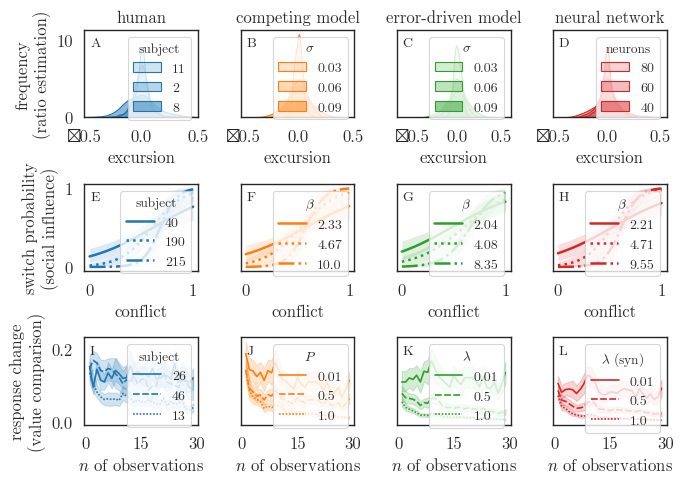

In [199]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(7,5), sharey='row')  # 

alphas = [0.2, 0.3, 0.5]
linestyles = ['-', ':', '-.']
sids_carrabin = [11, 2, 8]
sids_jiang = [40, 190, 215]
sids_yoo = [26, 46, 13]
noises = [0.03, 0.06, 0.09]
sigmas = [0.03, 0.06, 0.09]
neurons = [40, 60, 80]
subject_labels_carrabin = ["A", "B", "C"]
subject_labels_jiang = ["A", "B", "C"]
subject_labels_yoo = ["A", "B", "C"]

for i, subject in enumerate(sids_carrabin):
    sns.kdeplot(carrabin.query("type=='human' & sid==@subject"), x='excursion', ax=axes[0][0], color=palette[0],
                fill=True, common_norm=False, alpha=alphas[i], label=f"{sids_carrabin[i]}")
for i, noise in enumerate(noises):
    sns.kdeplot(carrabin.query("type=='B_n' & noise==@noise"), x='excursion', ax=axes[0][1], color=palette[1],
                fill=True, common_norm=False, alpha=alphas[i], label=f"{noise}")
for i, sigma in enumerate(sigmas):
    sns.kdeplot(carrabin.query("type=='RL_n' & sigma==@sigma"), x='excursion', ax=axes[0][2], color=palette[2],
                fill=True, common_norm=False, alpha=alphas[i], label=f"{sigma}")
for i, n in enumerate(neurons[::-1]):
    sns.kdeplot(carrabin.query("type=='NEF_syn' & neurons==@n"), x='excursion', ax=axes[0][3], color=palette[3],
                fill=True, common_norm=False, alpha=alphas[i], label=f"{n}")
axes[0][0].set(xlabel='excursion', xlim=[-0.5, 0.5], ylabel='frequency\n(ratio estimation)')
axes[0][1].set(xlabel='excursion', ylabel=None)
axes[0][2].set(xlabel='excursion', ylabel=None)
axes[0][3].set(xlabel='excursion', ylabel=None)
axes[0][0].set_title('human')  #, color=palette[0])
axes[0][1].set_title('competing model')  #, color=palette[1])
axes[0][2].set_title('error-driven model')  #, color=palette[2])
axes[0][3].set_title('neural network')  #, color=palette[3])
axes[0][0].legend(title="subject", loc='upper right')
axes[0][1].legend(title=r"$\sigma$", loc='upper right')
axes[0][2].legend(title=r"$\sigma$", loc='upper right')
axes[0][3].legend(title="neurons", loc='upper right')


for i, subject in enumerate(sids_jiang):
    sns.regplot(jiang.query("type=='Human' & sid==@subject"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[0],
                line_kws={"linestyle": linestyles[i]}, ax=axes[1][0], label=f"{sids_jiang[i]}")
for n, subject in enumerate(sids_jiang):
    beta = pd.read_pickle("data/DG_z_jiang_mar7_params.pkl").query("sid==@subject")['beta'].unique()[0]
    sns.regplot(jiang.query("type=='DeGroot' & sid==@subject"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[1],
                line_kws={"linestyle": linestyles[n]}, ax=axes[1][1], label=f"{beta:.3}")
for n, subject in enumerate(sids_jiang):
    mt = jiang['type'].unique()[2]
    beta = pd.read_pickle("data/RL_z_jiang_mar7_params.pkl").query("sid==@subject")['beta'].unique()[0]
    sns.regplot(jiang.query("type==@mt & sid==@subject"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[2],
                line_kws={"linestyle": linestyles[n]}, ax=axes[1][2], label=f"{beta:.3}")
for n, subject in enumerate(sids_jiang):
    mt = jiang['type'].unique()[3]
    beta = pd.read_pickle("data/NEF_syn_jiang_apr18_params.pkl").query("sid==@subject")['beta'].unique()[0]
    sns.regplot(jiang.query("type==@mt & sid==@subject"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[3],
                line_kws={"linestyle": linestyles[n]}, ax=axes[1][3], label=f"{beta:.3}")
axes[1][0].set(xlabel='conflict', ylabel='switch probability\n(social influence)')
axes[1][1].set(xlabel='conflict', ylabel=None)
axes[1][2].set(xlabel='conflict', ylabel=None)
axes[1][3].set(xlabel='conflict', ylabel=None)
axes[1][0].legend(title="subject", loc='upper right')
axes[1][1].legend(title=r"$\beta$", loc='upper right')
axes[1][2].legend(title=r"$\beta$", loc='upper right')
axes[1][3].legend(title=r"$\beta$", loc='upper right')


human = yoo['type'].unique()[0]
adm = yoo['type'].unique()[1]
rl = yoo['type'].unique()[2]
nef = yoo['type'].unique()[3]

sns.lineplot(yoo.query("type==@human"), x='stage', y='deltaR', ax=axes[2][0], color=palette[0], style='sid', style_order=sids_yoo)
sns.lineplot(yoo.query("type==@adm"), x='stage', y='deltaR', ax=axes[2][1], color=palette[1], style='lambd')
sns.lineplot(yoo.query("type==@rl"), x='stage', y='deltaR', ax=axes[2][2], color=palette[2], style='lambd')
sns.lineplot(yoo.query("type==@nef"), x='stage', y='deltaR', ax=axes[2][3], color=palette[3], style='lambd')
axes[2][0].set(xlabel=r"$n$ of observations", xticks=[0,15,30], ylabel="response change\n(value comparison)")
axes[2][1].set(xlabel=r"$n$ of observations", xticks=[0,15,30])
axes[2][2].set(xlabel=r"$n$ of observations", xticks=[0,15,30])
axes[2][3].set(xlabel=r"$n$ of observations", xticks=[0,15,30])
axes[2][0].legend(title="subject", loc='upper right')
axes[2][1].legend(title=r"$P$", loc='upper right')
axes[2][2].legend(title=r"$\lambda$", loc='upper right')
axes[2][3].legend(title=r"$\lambda$ (syn)", loc='upper right')

axes[0][0].text(0.05, 0.92, 'A', transform=axes[0][0].transAxes, fontsize=10, va='top', ha='left')
axes[0][1].text(0.05, 0.92, 'B', transform=axes[0][1].transAxes, fontsize=10, va='top', ha='left')
axes[0][2].text(0.05, 0.92, 'C', transform=axes[0][2].transAxes, fontsize=10, va='top', ha='left')
axes[0][3].text(0.05, 0.92, 'D', transform=axes[0][3].transAxes, fontsize=10, va='top', ha='left')
axes[1][0].text(0.05, 0.92, 'E', transform=axes[1][0].transAxes, fontsize=10, va='top', ha='left')
axes[1][1].text(0.05, 0.92, 'F', transform=axes[1][1].transAxes, fontsize=10, va='top', ha='left')
axes[1][2].text(0.05, 0.92, 'G', transform=axes[1][2].transAxes, fontsize=10, va='top', ha='left')
axes[1][3].text(0.05, 0.92, 'H', transform=axes[1][3].transAxes, fontsize=10, va='top', ha='left')
axes[2][0].text(0.05, 0.92, 'I', transform=axes[2][0].transAxes, fontsize=10, va='top', ha='left')
axes[2][1].text(0.05, 0.92, 'J', transform=axes[2][1].transAxes, fontsize=10, va='top', ha='left')
axes[2][2].text(0.05, 0.92, 'K', transform=axes[2][2].transAxes, fontsize=10, va='top', ha='left')
axes[2][3].text(0.05, 0.92, 'L', transform=axes[2][3].transAxes, fontsize=10, va='top', ha='left')

fig.tight_layout()
fig.savefig("figures/figure5a.svg")

## Tasks in columns

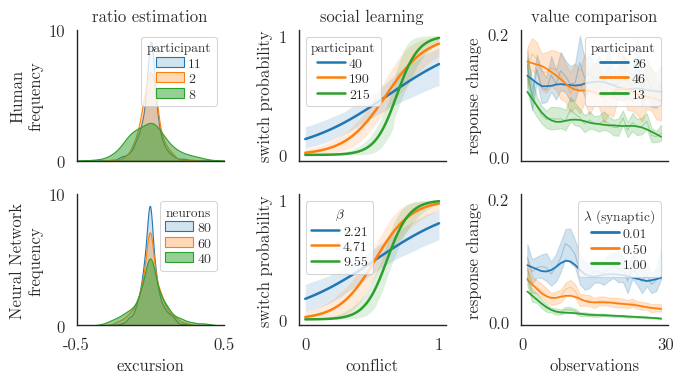

In [270]:
# ---------------------------------------------------
# Figure setup
# ---------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7,4), sharey='col', sharex='col')
axH0, axH1, axH2 = axes[0]   # Human   (Carrabin, Jiang, Yoo)
axN0, axN1, axN2 = axes[1]   # Neural  (Carrabin, Jiang, Yoo)

alphas = [0.2, 0.3, 0.5]
sids_carrabin = [11, 2, 8]
sids_jiang = [40, 190, 215]
sids_yoo = [13, 46, 26]
neurons = [40, 60, 80]

# =====================================================
# COLUMN 1: CARRABIN
# =====================================================
# --- Human
for i, subject in enumerate(sids_carrabin):
    sns.kdeplot(
        carrabin.query("type=='human' & sid==@subject"),
        x='excursion', ax=axH0, color=palette[i],
        fill=True, alpha=alphas[i], common_norm=False,
        label=f"{subject}"
    )
axH0.set(xlabel='excursion', xlim=[-0.5, 0.5], ylabel='Human\nfrequency', yticks=[0,10])
axH0.set_title("ratio estimation")
axH0.legend(title="subject", loc='upper right')

# --- Neural
for i, n in enumerate(neurons[::-1]):
    sns.kdeplot(
        carrabin.query("type=='NEF_syn' & neurons==@n"),
        x='excursion', ax=axN0, color=palette[i],
        fill=True, alpha=alphas[i], common_norm=False,
        label=f"{n}"
    )
axN0.set(xlabel='excursion', ylabel='Neural Network\nfrequency', xticks=[-0.5,0.5], yticks=[0,10])
axN0.legend(title="neurons", loc='upper right')
axN0.xaxis.set_major_formatter(mticker.FormatStrFormatter('%0.1f'.replace('−','-')))

# =====================================================
# COLUMN 2: JIANG
# =====================================================
# --- Human
for i, subject in enumerate(sids_jiang):
    sns.regplot(
        jiang.query("type=='Human' & sid==@subject"),
        x='conflict', y='switch',
        logistic=True, scatter=False,
        color=palette[i],
        ax=axH1, label=f"{subject}"
    )
axH1.set(xlabel=None, ylabel='switch probability', yticks=[0,1])
axH1.set_title("social learning")
axH1.legend(title="subject", loc='upper left')

# --- Neural
for i, subject in enumerate(sids_jiang):
    beta = pd.read_pickle("data/NEF_syn_jiang_apr18_params.pkl").query("sid==@subject")['beta'].unique()[0]
    sns.regplot(
        jiang.query("type=='NEF_syn' & sid==@subject"),
        x='conflict', y='switch',
        logistic=True, scatter=False,
        color=palette[i],
        ax=axN1, label=f"{beta:.3}"
    )
axN1.set(xlabel='conflict', ylabel='switch probability', yticks=[0,1])
axN1.legend(title=r"$\beta$", loc='upper left')

# =====================================================
# COLUMN 3: YOO
# =====================================================
human = yoo['type'].unique()[0]
nef   = yoo['type'].unique()[3]

# Extract the dataframe
dfH = yoo.query("type==@human")[['stage','deltaR','sid']]
dfHs = lowess_smooth_group(dfH, 'stage', 'deltaR', 'sid', frac=0.25)

# Manual order and colors
sids_manual = [26, 46, 13]               # new desired order
palette_manual = [palette[0], palette[1], palette[2]]  # assign colors as you like

# Plot each subject manually
for i, sid in enumerate(sids_manual):
    # Smoothed line
    sns.lineplot(dfHs.query("sid==@sid"), x='stage', y='deltaR', color=palette_manual[i], ax=axH2, legend=False)
    # Raw data (faded)
    sns.lineplot(dfH.query("sid==@sid"),x='stage', y='deltaR',color=palette_manual[i],alpha=0.3, linewidth=0.8,ax=axH2, legend=False)

# Set axes
axH2.set(ylabel='response change', title="value comparison", yticks=[0,0.25])

# Build legend manually
handles = [Line2D([0], [0], color=palette_manual[i], lw=2) for i in range(len(sids_manual))]
Hlabels = [str(sid) for sid in sids_manual]
axH2.legend(handles=handles, labels=Hlabels, title="subject", loc='upper right')

# --- Neural Network
dfN = yoo.query("type==@nef")[['stage','deltaR','lambd']]
dfNs = lowess_smooth_group(dfN, 'stage', 'deltaR', 'lambd', frac=0.25)
sns.lineplot(
    dfNs, x='stage', y='deltaR', hue='lambd',
    palette=[palette[i] for i in range(dfNs['lambd'].nunique())],
    ax=axN2, legend=False
)
sns.lineplot(
    dfN, x='stage', y='deltaR', hue='lambd',
    ax=axN2, palette=[palette[i] for i in range(dfN['lambd'].nunique())],
    alpha=0.3, linewidth=0.8, legend=False
)
axN2.set(xlabel="observations", xticks=[0, 30], ylabel='response change', yticks=[0,0.2])
# Build legend manually
lambdas_sorted = sorted(dfNs['lambd'].unique())
handles = [Line2D([0], [0], color=palette[i], lw=2) for i in range(len(lambdas_sorted))]
Nlabels = [f"{l:.2f}" for l in lambdas_sorted]
axN2.legend(handles=handles, labels=Nlabels, title=r"$\lambda$ (synaptic)", loc='upper right')
axN2.set(xlabel="observations", xticks=[0, 30], ylabel='response change', yticks=[0,0.2])


# =====================================================
# DESPINE
# =====================================================
for axrow in axes:
    for ax in axrow:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
axH0.legend(title="participant", loc='upper right', handletextpad=0.3, labelspacing=0.2)
axH1.legend(title="participant", loc='upper left', handletextpad=0.3, labelspacing=0.2)
axH2.legend(handles=handles, labels=Hlabels, title="participant",
            loc='upper right', handletextpad=0.3, labelspacing=0.2)
axN0.legend(title="neurons", loc='upper right', handletextpad=0.3, labelspacing=0.2)
axN1.legend(title=r"$\beta$", loc='upper left', handletextpad=0.3, labelspacing=0.2)
axN2.legend(handles=handles, labels=Nlabels, title=r"$\lambda$ (synaptic)",
            loc='upper right', handletextpad=0.3, labelspacing=0.2)

fig.tight_layout()
fig.savefig("figures/figure5a.svg")

# Figure 6 - Distributions of temporal discounting parameters

## Full

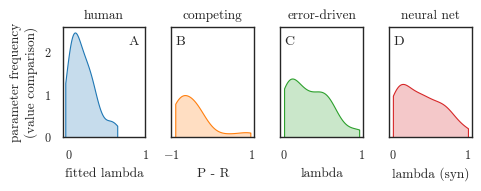

In [54]:
yoo = pd.read_pickle("data/temporal_weighting_powerlaw.pkl")
adm = pd.read_pickle("data/ADM_yoo_apr25_params.pkl")
rl = pd.read_pickle("data/RL_l_yoo_apr25_params.pkl")
nef = pd.read_pickle("data/NEF_syn_yoo_apr16_params.pkl")
primacy_minus_recency = adm['primacy'].to_numpy() - adm['recency'].to_numpy()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(5, 2), sharey=True)
sns.kdeplot(yoo, x='lambda', fill=True, common_norm=False, cut=0, ax=axes[0], color=palette[0])
sns.kdeplot(primacy_minus_recency, fill=True, common_norm=False, cut=0, ax=axes[1], color=palette[1])
sns.kdeplot(rl, x='lambda', fill=True, common_norm=False, cut=0, ax=axes[2], color=palette[2])
sns.kdeplot(nef, x='lambda', fill=True, common_norm=False, cut=0, ax=axes[3], color=palette[3])
axes[0].set(xlabel="fitted lambda", xticks=[0, 1], title="human", ylabel="parameter frequency\n(value comparison)")
axes[1].set(xlabel="P - R", xticks=[-1, 1], title="competing")
axes[2].set(xlabel="lambda", xticks=[0, 1], title="error-driven")
axes[3].set(xlabel="lambda (syn)", xticks=[0, 1],title="neural net")
axes[0].text(0.8, 0.92, 'A', transform=axes[0].transAxes, fontsize=10, va='top', ha='left')
axes[1].text(0.05, 0.92, 'B', transform=axes[1].transAxes, fontsize=10, va='top', ha='left')
axes[2].text(0.05, 0.92, 'C', transform=axes[2].transAxes, fontsize=10, va='top', ha='left')
axes[3].text(0.05, 0.92, 'D', transform=axes[3].transAxes, fontsize=10, va='top', ha='left')
plt.tight_layout()
fig.savefig("figures/discounting_parameters.jpg", dpi=600)

## One panel

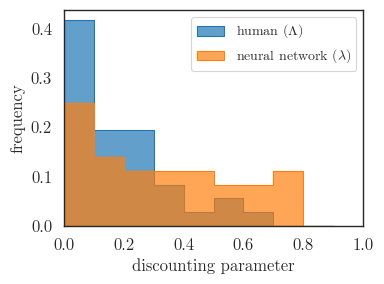

In [304]:
yoo = pd.read_pickle("data/temporal_weighting_powerlaw.pkl")
nef = pd.read_pickle("data/NEF_syn_yoo_apr16_params.pkl")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
# sns.kdeplot(yoo, x='lambda', fill=True, ax=axes, cut=0, color=palette[0], label=r"human ($\Lambda$)")
# sns.kdeplot(nef, x='lambda', fill=True, ax=axes, cut=0, color=palette[1], label=r"neural network ($\lambda$)")
sns.histplot(yoo, x='lambda', bins=np.arange(0,1,0.1), element='step', alpha=0.7, stat='probability', ax=axes, color=palette[0], label=r"human ($\Lambda$)")
sns.histplot(nef, x='lambda', bins=np.arange(0,1,0.1), element='step', alpha=0.7, stat='probability', ax=axes, color=palette[1], label=r"neural network ($\lambda$)")
axes.set(xlabel="discounting parameter", xlim=[0,1], xticks=np.arange(0,1.2,0.2), ylabel="frequency")
axes.legend()
plt.tight_layout()
# fig.savefig("figures/figure6a.svg")
fig.savefig("figures/figure6.pdf")

# Figure 7 - Neural activity predictions

## 2x2

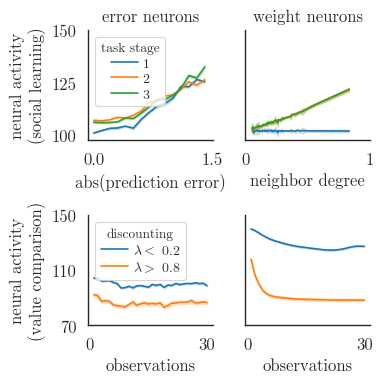

In [311]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4,4), sharey='row', sharex=False)

# -----------------------------
# Row 1: Jiang activities
# -----------------------------
sns.lineplot(
    activities_jiang.query("stage>0 & population=='error1' & aPE_bin<1.5"),
    x='aPE_bin', y='activity', hue='stage', ax=axes[0][0], palette=palette[:3], legend='full'
)
sns.lineplot(
    activities_jiang.query("stage>0 & population=='weight'"),
    x='RD', y='activity', hue='stage', ax=axes[0][1], palette=palette[:3], legend=False
)

axes[0][0].set(title="error neurons", ylabel="neural activity\n(social learning)", xlabel="abs(prediction error)", xticks=[0, 1.5], yticks=[100, 125, 150])
axes[0][1].set(title="weight neurons", ylabel=None, xticks=[0,1.0], xlabel="neighbor degree")

# -----------------------------
# Row 2: Yoo activities
# -----------------------------
sns.lineplot(
    activities_yoo.query("lambd<@lambda_small & population=='error1'"),
    x='stage', y='activity', ax=axes[1][0], color=palette[0], label=r"$\lambda <$ "+f"{lambda_small}"
)
sns.lineplot(
    activities_yoo.query("lambd>@lambda_large & population=='error1'"),
    x='stage', y='activity', ax=axes[1][0], color=palette[1], label=r"$\lambda >$ "+f"{lambda_large}"
)
sns.lineplot(
    activities_yoo.query("lambd<@lambda_small & population=='weight'"),
    x='stage', y='activity', ax=axes[1][1], color=palette[0], legend=False
)
sns.lineplot(
    activities_yoo.query("lambd>@lambda_large & population=='weight'"),
    x='stage', y='activity', ax=axes[1][1], color=palette[1], legend=False
)

axes[1][0].set(xlabel="observations", ylabel='neural activity\n(value comparison)', xticks=[0,30], yticks=[70, 110, 150])
axes[1][1].set(xlabel="observations", xticks=[0,30])


# Row 1 legend (Jiang, error population)
axes[0][0].legend(title="task stage",loc='upper left',handletextpad=0.3,labelspacing=0.2)

# Row 2 legend (Yoo, error population)
axes[1][0].legend(title="discounting", loc='upper left', handletextpad=0.3,labelspacing=0.2)

# -----------------------------
# Despine and layout
# -----------------------------
for axrow in axes:
    for ax in axrow:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig("figures/figure7a.svg")

# 1x4

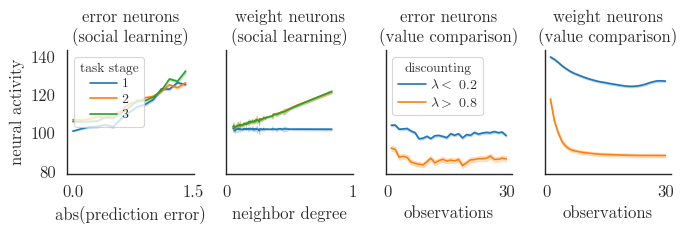

In [335]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(7, 2.5), sharey=True, sharex=False)

# -----------------------------
# Jiang activities
# -----------------------------
sns.lineplot(
    activities_jiang.query("stage>0 & population=='error1' & aPE_bin<1.5"),
    x='aPE_bin', y='activity', hue='stage', ax=axes[0], palette=palette[:3], legend='full'
)
sns.lineplot(
    activities_jiang.query("stage>0 & population=='weight'"),
    x='RD', y='activity', hue='stage', ax=axes[1], palette=palette[:3], legend=False
)

axes[0].set(title="error neurons\n(social learning)", ylabel="neural activity", xlabel="abs(prediction error)",
            xticks=[0, 1.5], yticks=[80, 100, 120, 140])
axes[1].set(title="weight neurons\n(social learning)", xticks=[0,1.0], xlabel="neighbor degree")

# -----------------------------
# Yoo activities
# -----------------------------
sns.lineplot(
    activities_yoo.query("lambd<@lambda_small & population=='error1'"),
    x='stage', y='activity', ax=axes[2], color=palette[0], label=r"$\lambda <$ "+f"{lambda_small}"
)
sns.lineplot(
    activities_yoo.query("lambd>@lambda_large & population=='error1'"),
    x='stage', y='activity', ax=axes[2], color=palette[1], label=r"$\lambda >$ "+f"{lambda_large}"
)
sns.lineplot(
    activities_yoo.query("lambd<@lambda_small & population=='weight'"),
    x='stage', y='activity', ax=axes[3], color=palette[0], legend=False
)
sns.lineplot(
    activities_yoo.query("lambd>@lambda_large & population=='weight'"),
    x='stage', y='activity', ax=axes[3], color=palette[1], legend=False
)

axes[2].set(title="error neurons\n(value comparison)", xlabel="observations", xticks=[0,30])
axes[3].set(title="weight neurons\n(value comparison)", xlabel="observations", xticks=[0,30])

# -----------------------------
# Legends
# -----------------------------
axes[0].legend(title="task stage", loc='upper left', handletextpad=0.3, labelspacing=0.2)
axes[2].legend(title="discounting", loc='upper left', handletextpad=0.3, labelspacing=0.2)

# -----------------------------
# Despine and layout
# -----------------------------
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig("figures/figure7a.svg")

# Figure 8 - Synaptic vs Recurrent Predictions

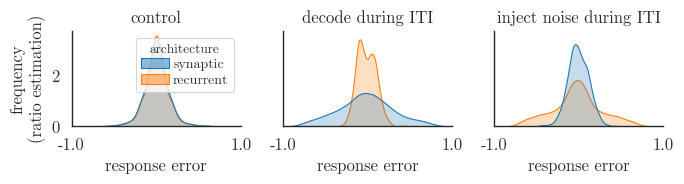

In [333]:
error_data_normal_decode = pd.read_pickle("data/error_normal_decode.pkl")
error_data_iti_decode = pd.read_pickle("data/error_iti_decode.pkl")
error_data_iti_noise = pd.read_pickle("data/error_iti_noise.pkl")
error_data_normal_decode['type'] = error_data_normal_decode['type'].replace("NEF_syn", "synaptic")
error_data_normal_decode['type'] = error_data_normal_decode['type'].replace("NEF_rec", "recurrent")
error_data_iti_decode['type'] = error_data_iti_decode['type'].replace("NEF_syn", "synaptic")
error_data_iti_decode['type'] = error_data_iti_decode['type'].replace("NEF_rec", "recurrent")
error_data_iti_noise['type'] = error_data_iti_noise['type'].replace("NEF_syn", "synaptic")
error_data_iti_noise['type'] = error_data_iti_noise['type'].replace("NEF_rec", "recurrent")
order = ['synaptic', 'recurrent']
error_data_normal_decode.rename(columns={'type': 'neural net'}, inplace=True)
error_data_iti_decode.rename(columns={'type': 'neural net'}, inplace=True)
error_data_iti_noise.rename(columns={'type': 'neural net'}, inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7,2), sharey=True, sharex=True)
sns.kdeplot(error_data_normal_decode, x='error', hue='neural net', ax=axes[0], fill=True, common_norm=False, palette=palette[:2], hue_order=order)
sns.kdeplot(error_data_iti_decode, x='error', hue='neural net', ax=axes[1], fill=True, common_norm=False, palette=palette[:2], hue_order=order)
sns.kdeplot(error_data_iti_noise, x='error', hue='neural net', ax=axes[2], fill=True, common_norm=False, palette=palette[:2], hue_order=order)
axes[0].set(xlabel='response error', title='control', xlim=[-1,1], xticks=[-1,1], ylabel="frequency\n(ratio estimation)") 
axes[1].set(xlabel='response error', title='decode during ITI') 
axes[2].set(xlabel='response error', title='inject noise during ITI')
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%0.1f'.replace('−','-')))
axes[1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%0.1f'.replace('−','-')))
axes[2].xaxis.set_major_formatter(mticker.FormatStrFormatter('%0.1f'.replace('−','-')))
handles = [Patch(facecolor=palette[i] + (0.5,),  # RGBA with alpha
                 edgecolor=palette[i]) for i in range(2)]
labels = ['synaptic', 'recurrent']
axes[0].legend(handles=handles, labels=labels, title="architecture",
               loc='upper right', handletextpad=0.3, labelspacing=0.2)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
plt.tight_layout()
fig.savefig("figures/figure8a.svg")

# Figure S1
### Overall model performance

/tmp/ipykernel_2945930/2109074859.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(carrabin, x='type', y='loss', ax=axes[0], palette=palette[1:4], width=0.5)
/tmp/ipykernel_2945930/2109074859.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(jiang, x='type', y='loss', ax=axes[1], palette=palette[1:4], width=0.5)
/tmp/ipykernel_2945930/2109074859.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(yoo, x='type', y='loss', ax=axes[2], palette=palette[1:4], width=0.5)


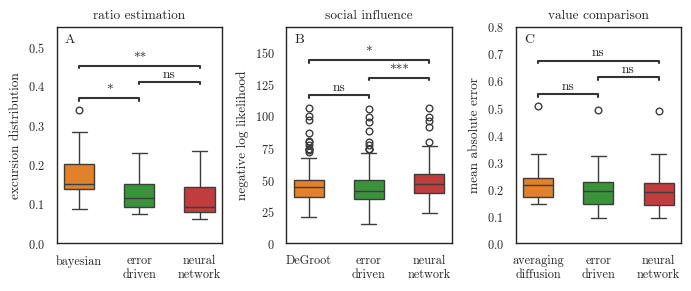

In [90]:
bayesian = pd.read_pickle("data/B_n_carrabin_mar6_performance.pkl")
rl = pd.read_pickle("data/RL_nl_carrabin_mar28_performance.pkl")
nef = pd.read_pickle("data/NEF_syn_carrabin_mar31_performance.pkl")
bayesian['type'] = "bayesian"
rl['type'] = "error\ndriven"
nef['type'] = "neural\nnetwork"
carrabin = pd.concat([bayesian, rl, nef], ignore_index=True)

degroot = pd.read_pickle("data/DG_z_jiang_mar7_performance.pkl")
rl = pd.read_pickle("data/RL_z_jiang_mar7_performance.pkl")
nef = pd.read_pickle("data/NEF_syn_jiang_apr7lambda0_performance.pkl")
degroot['type'] = "DeGroot"
rl['type'] = "error\ndriven"
nef['type'] = "neural\nnetwork"
jiang = pd.concat([degroot, rl, nef], ignore_index=True)

adm = pd.read_pickle("data/ADM_yoo_apr25_performance.pkl")
rl = pd.read_pickle("data/RL_l_yoo_apr25_performance.pkl")
nef = pd.read_pickle("data/NEF_syn_yoo_apr11_performance.pkl")
adm['type'] = "averaging\ndiffusion"
rl['type'] = "error\ndriven"
nef['type'] = "neural\nnetwork"
yoo = pd.concat([adm, rl, nef], ignore_index=True)

# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
# sns.boxplot(carrabin, x='type', y='loss', hue='type', ax=axes[0], palette=palette[1:4], notch=False, width=0.5) # , whis=(0, 100))
# sns.boxplot(jiang, x='type', y='loss', hue='type', ax=axes[1], palette=palette[1:4], notch=False, width=0.5) # , whis=(0, 100))
# sns.boxplot(yoo, x='type', y='loss', hue='type', ax=axes[2], palette=palette[1:4], notch=False, width=0.5) # , whis=(0, 100))
# axes[0].set(xlabel=None, ylabel='Excursion Distribution', ylim=[0, 0.4], title="Ratio Estimation Task") 
# axes[1].set(xlabel=None, ylabel='Negative Log Likelihood', ylim=[0, 120], title="Social Influence Task") 
# axes[2].set(xlabel=None, ylabel='Mean Absolute Error', title="Value Comparison Task") 
# plt.tight_layout()
# fig.savefig("figures/figureS1.jpg", dpi=600)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 3))

# Define your model comparison pairs (adjust if your labels are different)
pairs_carrabin = [('bayesian', 'error\ndriven'), ('bayesian', 'neural\nnetwork'), ('error\ndriven', 'neural\nnetwork')]
pairs_jiang = [('DeGroot', 'error\ndriven'), ('DeGroot', 'neural\nnetwork'), ('error\ndriven', 'neural\nnetwork')]
pairs_yoo = [('averaging\ndiffusion', 'error\ndriven'), ('averaging\ndiffusion', 'neural\nnetwork'), ('error\ndriven', 'neural\nnetwork')]

# Panel 1: Ratio Estimation Task
sns.boxplot(carrabin, x='type', y='loss', ax=axes[0], palette=palette[1:4], width=0.5)
annotator0 = Annotator(axes[0], pairs_carrabin, data=carrabin, x='type', y='loss')
annotator0.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0)
annotator0.apply_and_annotate()

# Panel 2: Social Influence Task
sns.boxplot(jiang, x='type', y='loss', ax=axes[1], palette=palette[1:4], width=0.5)
annotator1 = Annotator(axes[1], pairs_jiang, data=jiang, x='type', y='loss')
annotator1.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0)
annotator1.apply_and_annotate()

# Panel 3: Value Comparison Task
sns.boxplot(yoo, x='type', y='loss', ax=axes[2], palette=palette[1:4], width=0.5)
annotator2 = Annotator(axes[2], pairs_yoo, data=yoo, x='type', y='loss')
annotator2.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0)
annotator2.apply_and_annotate()

# Labeling and formatting
axes[0].set(xlabel=None, ylabel='excursion distribution', ylim=[0, 0.55], title="ratio estimation") 
axes[1].set(xlabel=None, ylabel='negative log likelihood', ylim=[0, 170], title="social influence") 
axes[2].set(xlabel=None, ylabel='mean absolute error', ylim=[0, 0.8], title="value comparison") 

axes[0].text(0.05, 0.97, 'A', transform=axes[0].transAxes, fontsize=10, va='top', ha='left')
axes[1].text(0.05, 0.97, 'B', transform=axes[1].transAxes, fontsize=10, va='top', ha='left')
axes[2].text(0.05, 0.97, 'C', transform=axes[2].transAxes, fontsize=10, va='top', ha='left')

plt.tight_layout()
fig.savefig("figures/si_performance.jpg", dpi=300)

# Figure S2
### Recreation of individual variability with models

In [24]:
carrabin = pd.read_pickle("data/excursions.pkl")
jiang = pd.read_pickle("data/switch_vs_conflict.pkl")
yoo = pd.read_pickle("data/temporal_weighting.pkl")
sids_carrabin = [8, 2, 11]
sids_jiang = [40, 190, 215]
sids_yoo = [13, 46, 26]
carrabin['type'] = carrabin['type'].replace('human', "Human")
carrabin['type'] = carrabin['type'].replace('Bayesian', "Baseline Model")
carrabin['type'] = carrabin['type'].replace('Reinforcement\nLearning', "Reinforcement Learning")
carrabin['type'] = carrabin['type'].replace('Neural\nNetwork', "Neural Network")

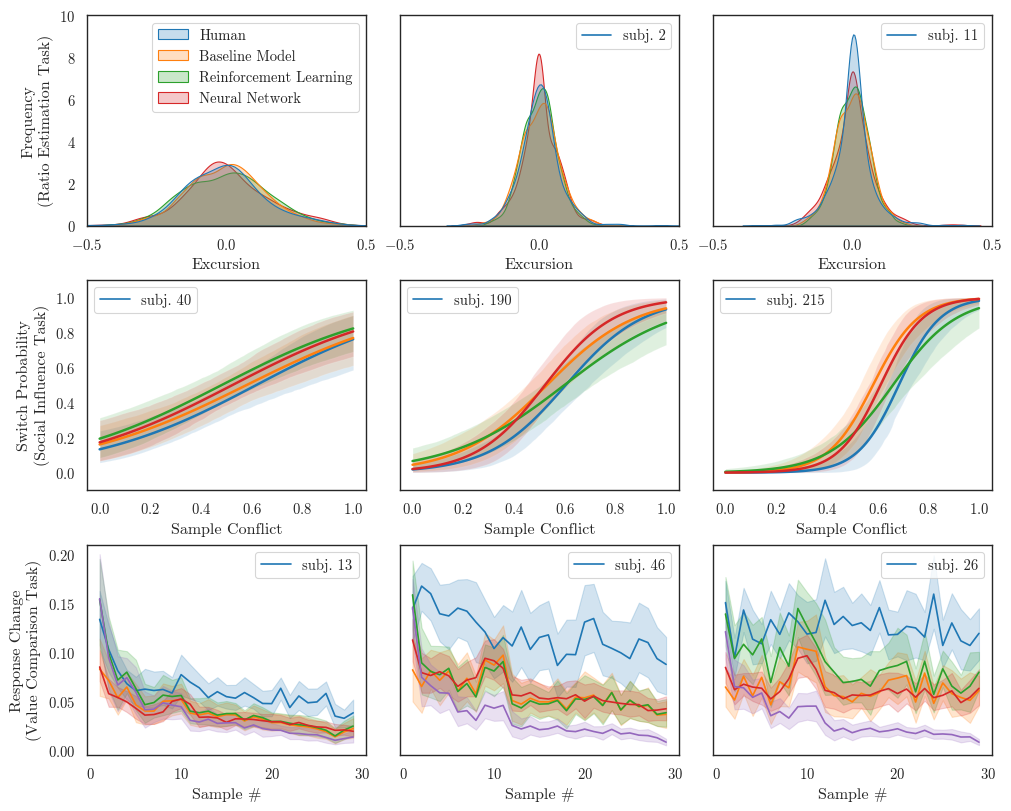

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,8), sharey='row', constrained_layout=True)

# Carrabin
sid1 = sids_carrabin[0]
sid2 = sids_carrabin[1]
sid3 = sids_carrabin[2]
sns.kdeplot(carrabin.query("sid==@sid1"), x="excursion", hue='type', palette=palette[:4], fill=True, common_norm=False, ax=axes[0][0])
sns.kdeplot(carrabin.query("sid==@sid2"), x="excursion", hue='type', palette=palette[:4], fill=True, common_norm=False, ax=axes[0][1])
sns.kdeplot(carrabin.query("sid==@sid3"), x="excursion", hue='type', palette=palette[:4], fill=True, common_norm=False, ax=axes[0][2])
axes[0][0].set(xlabel="Excursion", xlim=[-0.5, 0.5], xticks=[-0.5, 0, 0.5], ylim=[0, 10], ylabel='Frequency\n(Ratio Estimation Task)')  # , title=f"Subject {sid1}")
axes[0][1].set(xlabel="Excursion", xlim=[-0.5, 0.5], xticks=[-0.5, 0, 0.5], ylabel=None)
axes[0][2].set(xlabel="Excursion", xlim=[-0.5, 0.5], xticks=[-0.5, 0, 0.5], ylabel=None)
axes[0][1].get_legend().remove()
axes[0][2].get_legend().remove()
legend = axes[0][0].get_legend()
legend.set_title(None)  # Remove the legend title
legend._legend_box.align = "left"  # Fix alignment
blue_line2 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid2}")
blue_line3 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid3}")
axes[0][1].legend(handles=[blue_line2], loc='upper right')
axes[0][2].legend(handles=[blue_line3], loc='upper right')

# Jiang
sid1 = sids_jiang[0]
sid2 = sids_jiang[1]
sid3 = sids_jiang[2]
for mt, model_type in enumerate(jiang['type'].unique()):
    sns.regplot(jiang.query("sid==@sid1 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[1][0], label=model_type)
    sns.regplot(jiang.query("sid==@sid2 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[1][1], label=model_type)
    sns.regplot(jiang.query("sid==@sid3 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[1][2], label=model_type)
axes[1][0].set(xlabel="Sample Conflict", ylabel='Switch Probability\n(Social Influence Task)', ylim=[-0.1, 1.1])
axes[1][1].set(xlabel="Sample Conflict", ylim=[-0.1, 1.1], ylabel=None)
axes[1][2].set(xlabel="Sample Conflict", ylim=[-0.1, 1.1], ylabel=None)
blue_line1 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid1}")
blue_line2 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid2}")
blue_line3 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid3}")
axes[1][0].legend(handles=[blue_line1], loc='upper left')
axes[1][1].legend(handles=[blue_line2], loc='upper left')
axes[1][2].legend(handles=[blue_line3], loc='upper left')

# Yoo
sid1 = sids_yoo[0]
sid2 = sids_yoo[1]
sid3 = sids_yoo[2]
sns.lineplot(yoo.query("sid==@sid1"), x='stage', y='deltaR', hue='type', palette=palette[:5], ax=axes[2][0])
sns.lineplot(yoo.query("sid==@sid2"), x='stage', y='deltaR', hue='type', palette=palette[:5], ax=axes[2][1])
sns.lineplot(yoo.query("sid==@sid3"), x='stage', y='deltaR', hue='type', palette=palette[:5], ax=axes[2][2])
axes[2][0].set(ylabel="Response Change\n(Value Comparison Task)", xlabel="Sample #")
axes[2][1].set(ylabel=None, xlabel="Sample #")
axes[2][2].set(ylabel=None, xlabel="Sample #")
axes[2][0].get_legend().remove()
axes[2][1].get_legend().remove()
axes[2][2].get_legend().remove()
blue_line1 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid1}")
blue_line2 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid2}")
blue_line3 = mlines.Line2D([], [], color=palette[0], label=f"subj. {sid3}")
axes[2][0].legend(handles=[blue_line1], loc='upper right')
axes[2][1].legend(handles=[blue_line2], loc='upper right')
axes[2][2].legend(handles=[blue_line3], loc='upper right')

# plt.tight_layout()
fig.savefig("figures/figureS2.jpg", dpi=600)

# Figure S3
### Synaptic vs Recurrent Performance (group level)

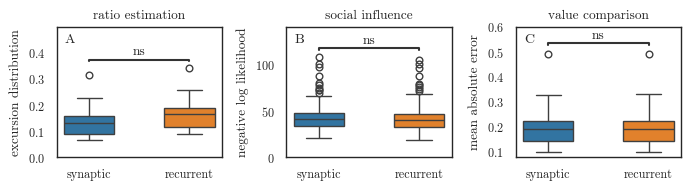

In [84]:
syn = pd.read_pickle("data/NEF_syn_carrabin_apr21_performance.pkl")
rec = pd.read_pickle("data/NEF_rec_carrabin_apr21_performance.pkl")
syn['type'] = "synaptic"
rec['type'] = "recurrent"
carrabin = pd.concat([syn, rec], ignore_index=True)
syn = pd.read_pickle("data/NEF_syn_jiang_apr18_performance.pkl")
rec = pd.read_pickle("data/NEF_rec_jiang_apr18_performance.pkl")
syn['type'] = "synaptic"
rec['type'] = "recurrent"
jiang = pd.concat([syn], ignore_index=True)
jiang = pd.concat([syn, rec], ignore_index=True)
syn = pd.read_pickle("data/NEF_syn_yoo_apr16_performance.pkl")
rec = pd.read_pickle("data/NEF_rec_yoo_apr16_performance.pkl")
syn['type'] = "synaptic"
rec['type'] = "recurrent"
yoo = pd.concat([syn, rec], ignore_index=True)

pairs = [('synaptic', 'recurrent')]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7,2))
sns.boxplot(carrabin, x='type', y='loss', hue='type', ax=axes[0], palette=palette[:2], notch=False, width=0.5) # , whis=(0, 100))
sns.boxplot(jiang, x='type', y='loss', hue='type', ax=axes[1], palette=palette[:2], notch=False, width=0.5) # , whis=(0, 100))
sns.boxplot(yoo, x='type', y='loss', hue='type', ax=axes[2], palette=palette[:2], notch=False, width=0.5) # , whis=(0, 100))
annotator0 = Annotator(axes[0], pairs, data=carrabin, x='type', y='loss')
annotator0.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0)
annotator0.apply_and_annotate()
annotator1 = Annotator(axes[1], pairs, data=carrabin, x='type', y='loss')
annotator1.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0)
annotator1.apply_and_annotate()
annotator2 = Annotator(axes[2], pairs, data=carrabin, x='type', y='loss')
annotator2.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0)
annotator2.apply_and_annotate()
axes[0].set(xlabel=None, ylabel='excursion distribution', ylim=[0, 0.5], yticks=np.arange(0.0, 0.5, 0.1), title="ratio estimation") 
axes[1].set(xlabel=None, ylabel='negative log likelihood', ylim=[0, 140], title="social influence") 
axes[2].set(xlabel=None, ylabel='mean absolute error', yticks=np.arange(0.1, 0.7, 0.1), title="value comparison") 

axes[0].text(0.05, 0.95, 'A', transform=axes[0].transAxes, fontsize=10, va='top', ha='left')
axes[1].text(0.05, 0.95, 'B', transform=axes[1].transAxes, fontsize=10, va='top', ha='left')
axes[2].text(0.05, 0.95, 'C', transform=axes[2].transAxes, fontsize=10, va='top', ha='left')

plt.tight_layout()
fig.savefig("figures/si_syn_vs_rec.jpg", dpi=600)

# Figure S4
### Weighting error analysis

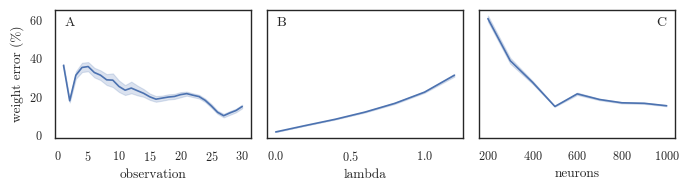

In [80]:
a = pd.read_pickle("data/weighting_error_neurons_may16.pkl")
b = pd.read_pickle("data/weighting_error_lambd_may16.pkl")
weight_data = pd.concat([a, b], ignore_index=True)
weight_data = weight_data.rename(columns={'lambda': 'lambd'})
weight_data['relative_error'] = 100*weight_data['relative_error']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2), sharey=True)
sns.lineplot(weight_data.query("n_neurons==500 & lambd==1.0"), x='stage', y='relative_error', ax=axes[0])
sns.lineplot(weight_data.query("n_neurons==500"), x='lambd', y='relative_error', ax=axes[1])
sns.lineplot(weight_data.query("n_neurons>=200"), x='n_neurons', y='relative_error', ax=axes[2])
axes[0].set(xlabel='observation', ylabel='weight error (%)', xticks=np.arange(0, 35, 5))
axes[1].set(xlabel="lambda")
axes[2].set(xlabel="neurons")  # , xticks=weight_data['n_neurons'].unique())
axes[0].text(0.05, 0.95, 'A', transform=axes[0].transAxes, fontsize=10, va='top', ha='left')
axes[1].text(0.05, 0.95, 'B', transform=axes[1].transAxes, fontsize=10, va='top', ha='left')
axes[2].text(0.9, 0.95, 'C', transform=axes[2].transAxes, fontsize=10, va='top', ha='left')
fig.tight_layout()
fig.savefig('figures/si_weight_error.jpg', dpi=600)

In [79]:
pd.read_pickle("data/weighting_error_neurons_may15b.pkl")

,type,sid,trial,stage,lambda,n_neurons,error
0,NEF_syn,1,1,1,1.0,100,0.802340
1,NEF_syn,1,1,2,1.0,100,0.844390
2,NEF_syn,1,1,3,1.0,100,1.043135
3,NEF_syn,1,1,4,1.0,100,1.315260
4,NEF_syn,1,1,5,1.0,100,1.557180
...,...,...,...,...,...,...,...
89995,NEF_syn,11,30,26,1.0,1000,0.053413
89996,NEF_syn,11,30,27,1.0,1000,0.050400
89997,NEF_syn,11,30,28,1.0,1000,0.118400
89998,NEF_syn,11,30,29,1.0,1000,0.111840
